$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \cW {\mathcal{W}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$

# Measurement-driven greedy algorithm

What is unique in this test is that we asses the measurement-driven greedy algorithms against a variety of different solutions $u_h$, and plot the variance of performance of these algorithms in a couple of different ways. 

Note that all the calculations have been offloaded to a heavy weight script: ```scripts/greedy_Vn/07_greedy_Vn_average_cases.py```. Here we simply import the results from this script.
 
We're given our measurement space $W_m = \mathrm{span}\{w_1,\ldots,w_m\}$. We have a series of measurements $\langle w_i, u\rangle_V$, and we write $w := P_{W_m} u$, the projection of $u$ in $W_m$. We do this for a variety of $u$

This algorithm makes a very simple adjustment to the greedy algorithm - it does the argmax search in the $W_m$ projection. Of course as $n \to m$ there is nothing we can do about $\beta(V_n, W_m) \to 0$.

For more information on the greedy algorithms, either see the write up or the earlier notebook ```02_greedy_Vn.ipynb```

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

results_file = '../../scripts/greedy_Vn/results/07_greedy_Vn_stats.npy'
stats = np.load(results_file)

/usr/local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


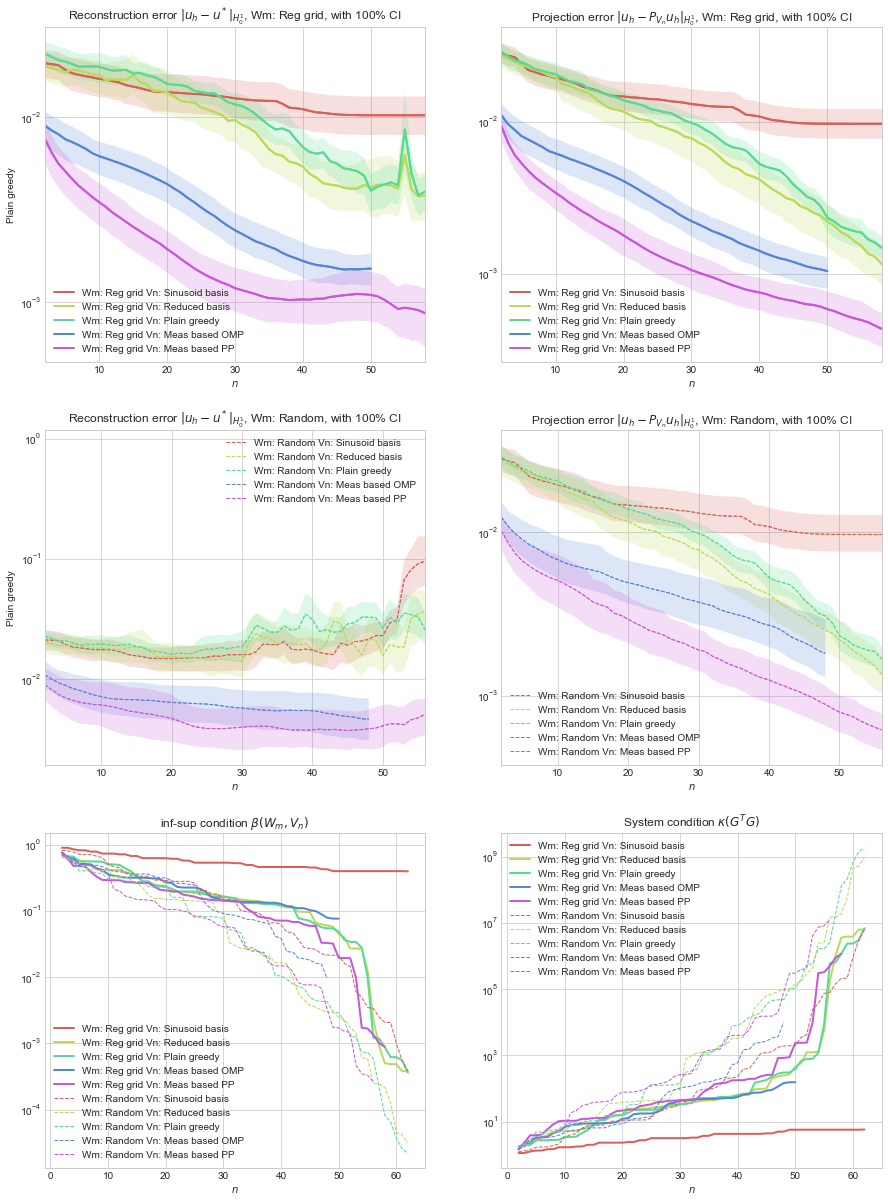

In [15]:
generic_Vns_labels = ['Sinusoid basis', 'Reduced basis', 'Plain greedy']
adapted_Vns_labels = ['Meas based OMP', 'Meas based PP']
Wm_labels = ['Reg grid', 'Random']

sns.set_palette('hls', len(generic_Vns_labels) + len(adapted_Vns_labels))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,1]

axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid, with 100% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Reg grid, with 100% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Random, with 100% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Random, with 100% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for i, Wm_label in enumerate(Wm_labels):
    for j, Vn_label in enumerate(generic_Vns_labels):
        
    
        #Vn_n = generic_Vns[j].n
        Vn_n = np.where(np.isclose((~np.isclose(stats[0, i, j, :, :], 0.0)).sum(axis=0), stats.shape[3]))[-1][-1]
        
        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        plt.sca(axs[i*2])
        sns.tsplot(stats[0, i, j, :, 2:Vn_n], range(2, Vn_n), value=Vn_label, ls=lss[i], lw=lws[i], color=cp[j], ci=[100])
        # Below is a duplicate plot just for getting the label in the legend...
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        sns.tsplot(stats[1, i, j, :, 2:Vn_n], range(2, Vn_n), ls=lss[i], lw=lws[i],color=cp[j], ci=[100])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
    for j_i, Vn_label in enumerate(adapted_Vns_labels):
        j = j_i + len(generic_Vns_labels)

        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        
        # Some funny biz about n...
        #Vn_ns = [Vn.n for Vn in adapted_Vns[i][j_i]]
        #Vn_n = min(Vn_ns)
        Vn_n = np.where(np.isclose((~np.isclose(stats[0, i, j, :, :], 0.0)).sum(axis=0), stats.shape[3]))[-1][-1]
        
        plt.sca(axs[i*2])
        sns.tsplot(stats[0, i, j, :, 2:Vn_n], range(2, Vn_n), ls=lss[i], lw=lws[i], color=cp[j], ci=[100])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])

        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        sns.tsplot(stats[1, i, j, :, 2:Vn_n], range(2, Vn_n), ls=lss[i], lw=lws[i], color=cp[j], ci=[100])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])        
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
plt.savefig('GreedyMeasSelectionResults.pdf')
plt.show()

# Old code follows below. Kept for some sense of posterity...

In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

def make_soln(points, fem_div, field_div, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = []
    fields = []

    for p in points:
        field = pat.PWConstantSqDyadicL2(a_bar + c * p.reshape((2**field_div,2**field_div)))
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = field, f = 1)
        fem_solver.solve()
        solns.append(fem_solver.u)
        
    return solns, fields

### Generate the solution $u$ that we want to approximate

In [2]:
fem_div = 7

a_bar = 1.0
c = 0.9
field_div = 2
side_n = 2**field_div

n_us = 40

np.random.seed(3)
points = 2*np.random.random((n_us, side_n*side_n)) - 1

us, fields = make_soln(points, fem_div, field_div, a_bar=a_bar, c=c, f=1.0)

plot = False
if plot:
    fig = plt.figure(figsize=(15, 21))
    for i, u in enumerate(us):
        ax = fig.add_subplot(n_us/5, 5, i+1, projection='3d')
        u.plot(ax)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    plt.show()

### Generate the basis $W_m$ of randomly placed local averages

m = 64


[]

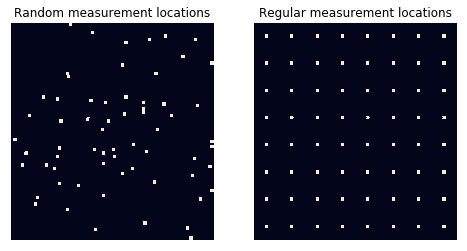

In [3]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
width_div = 1
local_width = 2**width_div
spacing_div = 4

Wm_reg, Wloc_reg = pat.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
Wm_reg = Wm_reg.orthonormalise()

m = Wm_reg.n
print('m =', m)

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

Wm_rand, Wloc = pat.make_pw_local_avg_random_basis(m=m, div=fem_div, width=local_width, return_map=True)
Wm_rand = Wm_rand.orthonormalise()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(Wloc.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Random measurement locations')
ax = fig.add_subplot(1, 2, 2)
sns.heatmap(Wloc_reg.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Regular measurement locations')
plt.plot()

### Generate the dictionary of random snapshots

In [4]:
N = int(1e4)
np.random.seed(1)
dict_basis, dict_fields = pat.make_pw_reduced_basis(N, field_div, fem_div, a_bar=a_bar, c=c, f=1.0, verbose=False)
dictionary = dict_basis.vecs

In [5]:
Vn_sin = pat.make_pw_sin_basis(div=fem_div, N=8)
Vn_red, Vn_red_fields = pat.make_pw_reduced_basis(m, field_div, fem_div, a_bar=a_bar, c=c, f=1.0, verbose=False)

g = pat.GreedyApprox(dictionary, Vn=pat.PWBasis(), verbose=False)
g.construct_to_n(m)

generic_Vns = [Vn_sin, Vn_red, g.Vn]
generic_Vns_labels = ['Sinusoid basis', 'Reduced basis', 'Plain greedy']

In [6]:
import copy

adapted_Vns = []
adapted_Vns_labels = ['Meas based OMP', 'Meas based PP']

for Wm, Wm_label in zip([Wm_reg, Wm_rand], ['Reg grid', 'Random']):

    algs = [pat.MeasBasedOMP(dictionary, us[0], Wm, Vn=pat.PWBasis(), verbose=True), 
            pat.MeasBasedPP(dictionary, us[0], Wm, Vn=pat.PWBasis(), verbose=True)]
    
    adapted_Vns.append([])
    adapted_Vns_labels.append([])
    
    # CALL CONSTRUCTOR HERE AND INITIALISE THE BIG DOT PROD DICTIONARY HERE YA DUMMY
    for alg, Vn_label in zip(algs, adapted_Vns_labels):
        adapted_Vns[-1].append([])
        #adapted_Vns_labels[-1].append([])
        for i, u in enumerate(us):
            if i > 0:
                alg.reset_u(u)

            alg.construct_to_n(m)
            adapted_Vns[-1][-1].append(alg.Vn)
            #adapted_Vns_labels[-1][-1].append(Vn_label)

i 	 Selection 	 Sel. criteria
1 : 	 7705 	 0.054204727112489914
2 : 	 4311 		 0.0029980688304073787
3 : 	 9563 		 0.00233082571032856
4 : 	 3509 		 0.0016326873940914236
5 : 	 2605 		 0.0010168884532911686
6 : 	 2311 		 0.0007628678089067727
7 : 	 4478 		 0.0004554463226773024
8 : 	 1132 		 0.00031053120667761134
9 : 	 2508 		 0.0003025803868404142
10 : 	 4773 		 0.000220075188992232
11 : 	 824 		 0.0002139246859014951
12 : 	 9329 		 0.00018151063990890916
13 : 	 3549 		 0.00011444846266729126
14 : 	 2412 		 9.586529845796806e-05
15 : 	 4136 		 8.871584237319158e-05
16 : 	 3592 		 7.028945995939715e-05
17 : 	 1174 		 5.5229160027554355e-05
18 : 	 3274 		 6.697521689033935e-05
19 : 	 5362 		 7.636269665685117e-05
20 : 	 2397 		 4.163651804517165e-05
21 : 	 5258 		 4.548329179367741e-05
22 : 	 4728 		 3.2781907722504994e-05
23 : 	 3011 		 2.941549948973763e-05
24 : 	 8958 		 3.118980377624352e-05
25 : 	 8946 		 2.9687740933125223e-05
26 : 	 2520 		 2.1657502625080458e-05
27 : 	 1313 		 2

54 : 	 1594 		 3.259006670305045e-08
Vn spans all dictionary points at n=54, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 5687 	 0.07308015235696433
2 : 	 1313 		 0.004522205551828846
3 : 	 2572 		 0.004092238145227162
4 : 	 1215 		 0.0019381613746312179
5 : 	 9039 		 0.0020604075227300686
6 : 	 3369 		 0.0012686103300888775
7 : 	 7587 		 0.001103924429179011
8 : 	 7143 		 0.0009336372251005495
9 : 	 5263 		 0.00046192825232157424
10 : 	 6471 		 0.0004250652515289385
11 : 	 5197 		 0.00041792326204198593
12 : 	 8565 		 0.00042646841533901616
13 : 	 6908 		 0.000365162142971667
14 : 	 4477 		 0.00028084394189658093
15 : 	 7870 		 0.00014572831826598634
16 : 	 2520 		 0.00014999049344248893
17 : 	 2397 		 0.00018288490301392548
18 : 	 2208 		 0.00011352561861377702
19 : 	 3192 		 7.90024686587085e-05
20 : 	 5305 		 0.00010037175223107548
21 : 	 6566 		 6.838640878790939e-05
22 : 	 831 		 5.197962966671078e-05
23 : 	 6482 		 4.891605616849046e-05
24 : 	 1791 		 4.758249776175

52 : 	 2576 		 4.0522689734070757e-07
53 : 	 2789 		 1.918723514883255e-07
54 : 	 5362 		 8.101700256918793e-08
Vn spans all dictionary points at n=54, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 628 	 0.06952276973939862
2 : 	 6433 		 0.0035751738309621724
3 : 	 6386 		 0.0026096124599743285
4 : 	 8293 		 0.0024376716672661826
5 : 	 9641 		 0.0019251070321554134
6 : 	 2825 		 0.0010057182695377255
7 : 	 3113 		 0.0009712326313658589
8 : 	 4471 		 0.0007098865057183696
9 : 	 6471 		 0.00046430296487847436
10 : 	 4527 		 0.00037673514801697346
11 : 	 8949 		 0.000538872578273369
12 : 	 406 		 0.0004318622342900516
13 : 	 4478 		 0.000333186955576488
14 : 	 3786 		 0.000202514001296646
15 : 	 6482 		 0.00021972602245897148
16 : 	 9366 		 0.00022725087672650744
17 : 	 8549 		 0.000233033561238246
18 : 	 9563 		 0.0002094491805273866
19 : 	 4943 		 0.0001101682560568664
20 : 	 4052 		 0.00011047121480063428
21 : 	 831 		 9.031307758928051e-05
22 : 	 2205 		 5.846971080946964e

50 : 	 5823 		 2.030508107942631e-07
51 : 	 6398 		 5.686730734364082e-08
52 : 	 2480 		 4.9909589635899165e-08
53 : 	 2921 		 2.389905359545617e-08
Vn spans all dictionary points at n=53, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 4761 	 0.06228354031843035
2 : 	 27 		 0.0044949489416214435
3 : 	 7771 		 0.0032257241301823975
4 : 	 5215 		 0.001852247493281774
5 : 	 4478 		 0.0010361061492463622
6 : 	 8578 		 0.0010417449808647352
7 : 	 6895 		 0.00038263320646531214
8 : 	 3506 		 0.00027607814442065205
9 : 	 9436 		 0.00026119548175473277
10 : 	 2412 		 0.00024361665354982027
11 : 	 7955 		 0.0002103451473565343
12 : 	 9959 		 0.00018774502358285188
13 : 	 9094 		 0.00023052059582665723
14 : 	 2770 		 0.00023856987698866254
15 : 	 6943 		 0.00015740224349655428
16 : 	 1791 		 0.00013423397337292175
17 : 	 9590 		 0.0001727935573015808
18 : 	 3178 		 6.232905911925693e-05
19 : 	 2576 		 9.081687436759132e-05
20 : 	 26 		 7.452994721161889e-05
21 : 	 7770 		 4.9482592301

50 : 	 26 		 6.061393596526695e-07
51 : 	 693 		 4.0756548951458753e-07
52 : 	 1758 		 1.8118880329934917e-07
53 : 	 3162 		 5.808395280720635e-08
Vn spans all dictionary points at n=53, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 4008 	 0.047056747326859036
2 : 	 1936 		 0.002500621889691379
3 : 	 9094 		 0.0016782843348399092
4 : 	 8038 		 0.0013509937176815032
5 : 	 536 		 0.0009724735103818091
6 : 	 2373 		 0.0005605315410242358
7 : 	 6471 		 0.00039005007150367914
8 : 	 868 		 0.0003475176476693494
9 : 	 8402 		 0.00018675748308348902
10 : 	 972 		 0.00017695375095633215
11 : 	 9518 		 0.00013818971831883317
12 : 	 9810 		 0.00015326285989205365
13 : 	 5362 		 0.00012062910718053907
14 : 	 2208 		 0.00011956426160129614
15 : 	 6180 		 0.00014486340106135937
16 : 	 782 		 0.000120144100018235
17 : 	 7163 		 6.955962026758948e-05
18 : 	 3011 		 8.02757470508045e-05
19 : 	 6720 		 9.294119456295985e-05
20 : 	 6741 		 4.5779083918907356e-05
21 : 	 7353 		 3.0168388578293

53 : 	 46 		 1.77011135345801e-07
54 : 	 3667 		 1.041119023737919e-07
55 : 	 8277 		 5.660494216059993e-08
Vn spans all dictionary points at n=55, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 5077 	 0.0446652676120986
2 : 	 5621 		 0.002139376052504912
3 : 	 7549 		 0.0017243023590678343
4 : 	 4714 		 0.001033605749416477
5 : 	 2793 		 0.0007325936642631181
6 : 	 1066 		 0.0004822514774100345
7 : 	 2373 		 0.0003514360839029063
8 : 	 3862 		 0.0002342430627566517
9 : 	 959 		 0.00013991584634872822
10 : 	 2397 		 0.00011333712272458289
11 : 	 3798 		 7.109543973607987e-05
12 : 	 2254 		 8.401132229848566e-05
13 : 	 6386 		 9.085564536318586e-05
14 : 	 8039 		 6.870607601996765e-05
15 : 	 7205 		 8.893086203250143e-05
16 : 	 3990 		 6.982498378384919e-05
17 : 	 3695 		 5.755426677911761e-05
18 : 	 868 		 4.566911383549328e-05
19 : 	 1276 		 5.5863352475655356e-05
20 : 	 3192 		 3.356047040430086e-05
21 : 	 8101 		 3.4689816237197684e-05
22 : 	 605 		 3.513701438085782e-05


48 : 	 8564 		 2.891990293674735e-07
49 : 	 2317 		 2.1118946763163795e-07
50 : 	 8197 		 1.9599269485715063e-07
51 : 	 1066 		 2.3358095896637125e-07
52 : 	 9110 		 1.0761389776522264e-07
53 : 	 5006 		 1.0045137881371506e-07
54 : 	 3132 		 3.317904788978923e-08
Vn spans all dictionary points at n=54, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 4440 	 0.04572350587484214
2 : 	 5460 		 0.002468122604692594
3 : 	 6644 		 0.001219410506044694
4 : 	 8396 		 0.0010480340901108107
5 : 	 9136 		 0.0004771163453025389
6 : 	 4324 		 0.00028449231570304797
7 : 	 4052 		 0.0002441834722112782
8 : 	 9563 		 0.00020667949206686976
9 : 	 9517 		 0.00016496983652194137
10 : 	 6895 		 0.00012472675640448264
11 : 	 2159 		 0.0001300767319696486
12 : 	 3862 		 8.826039624098539e-05
13 : 	 730 		 9.530391090375944e-05
14 : 	 5362 		 6.618436061348246e-05
15 : 	 6386 		 5.749156962037085e-05
16 : 	 8702 		 6.166279492804351e-05
17 : 	 2576 		 6.934480689093966e-05
18 : 	 3119 		 5.452613385

46 : 	 1791 		 6.697773089475209e-07
47 : 	 7008 		 4.2419612907157845e-07
48 : 	 252 		 4.6138392694768573e-07
49 : 	 6741 		 3.354242082092389e-07
50 : 	 5232 		 1.864617331634253e-07
51 : 	 560 		 8.443803966459773e-08
52 : 	 7939 		 2.3507546202180222e-08
53 : 	 6398 		 1.8253115339967703e-08
54 : 	 1917 		 1.0803874499598761e-08
Vn spans all dictionary points at n=54, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 4196 	 0.0538280150899631
2 : 	 9079 		 0.0036554755323146056
3 : 	 4285 		 0.00191900383617884
4 : 	 7112 		 0.001131223085349758
5 : 	 8759 		 0.0010388593264975168
6 : 	 7917 		 0.0008019736221339738
7 : 	 6201 		 0.0006004525382643027
8 : 	 310 		 0.00029868213453904525
9 : 	 1132 		 0.00030658068187459475
10 : 	 3198 		 0.00019502363461021275
11 : 	 4202 		 0.00012814745654719873
12 : 	 881 		 0.0001126886739613255
13 : 	 3369 		 8.210423011652814e-05
14 : 	 6165 		 9.356558994122859e-05
15 : 	 5362 		 8.774775226336649e-05
16 : 	 6032 		 8.82129482045912

44 : 	 4728 		 1.043424605567791e-06
45 : 	 5688 		 1.6858348919522834e-06
46 : 	 8549 		 1.0598221588006728e-06
47 : 	 4838 		 8.864133343378899e-07
48 : 	 2789 		 1.0170775724451594e-06
49 : 	 1658 		 4.090865447051375e-07
50 : 	 2520 		 3.0654686846059536e-07
51 : 	 3645 		 2.491487317614942e-07
52 : 	 7274 		 2.4887000276438613e-07
53 : 	 6471 		 1.7665810709285271e-07
54 : 	 204 		 7.836808359261481e-08
55 : 	 3354 		 2.6491372856393424e-08
Vn spans all dictionary points at n=55, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 7615 	 0.0567574988621521
2 : 	 2296 		 0.003290109853718806
3 : 	 6817 		 0.002427764004686179
4 : 	 868 		 0.0019679773715325435
5 : 	 1174 		 0.001028621889718544
6 : 	 7757 		 0.0008363892455772414
7 : 	 5362 		 0.0007044627534898114
8 : 	 6201 		 0.0006716343346597688
9 : 	 1297 		 0.0005746034903691573
10 : 	 1320 		 0.0004071665552908672
11 : 	 8460 		 0.00045211715711113333
12 : 	 2412 		 0.0002933990110531408
13 : 	 9628 		 0.0002626542109

41 : 	 693 		 1.2540362279131036e-06
42 : 	 27 		 9.046657234399128e-07
43 : 	 6653 		 7.790789646887337e-07
44 : 	 7688 		 5.807730541982668e-07
45 : 	 2851 		 7.447220765203839e-07
46 : 	 1268 		 8.808537670995484e-07
47 : 	 2520 		 3.9164601422478966e-07
48 : 	 4930 		 3.849647710851445e-07
49 : 	 8293 		 2.9431358024828527e-07
50 : 	 2608 		 1.584986157378576e-07
51 : 	 9440 		 1.1395048185834246e-07
52 : 	 505 		 7.690109844362717e-08
53 : 	 4728 		 6.634624347347399e-08
54 : 	 8728 		 2.391469227139495e-08
Vn spans all dictionary points at n=54, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 7352 	 0.06357760005196314
2 : 	 1375 		 0.006378528893990576
3 : 	 6180 		 0.0025215061225024684
4 : 	 8515 		 0.0015526323350193237
5 : 	 3877 		 0.0010083803053663758
6 : 	 6741 		 0.0008735952400613279
7 : 	 3590 		 0.0006470200922899951
8 : 	 1886 		 0.0005129810299488544
9 : 	 8443 		 0.0004707046949656713
10 : 	 3927 		 0.0004930202149086473
11 : 	 4970 		 0.0004695117984169

38 : 	 1860 		 2.5359461407592132e-06
39 : 	 1449 		 2.48794515980334e-06
40 : 	 8549 		 2.125942236412321e-06
41 : 	 15 		 1.5716204470468084e-06
42 : 	 6406 		 1.4724689943784982e-06
43 : 	 8246 		 1.0319779722898383e-06
44 : 	 3667 		 1.605609665234164e-06
45 : 	 3317 		 7.558836963941346e-07
46 : 	 1066 		 7.620526703926264e-07
47 : 	 6990 		 4.526025089537497e-07
48 : 	 5038 		 3.068295838973878e-07
49 : 	 7721 		 2.6353733125681456e-07
50 : 	 733 		 1.6975625750066305e-07
51 : 	 6052 		 7.470249459803466e-08
52 : 	 3212 		 6.652749360832097e-08
53 : 	 8121 		 2.8413158065049704e-08
54 : 	 6949 		 1.7312944018224734e-08
Vn spans all dictionary points at n=54, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 7705 	 0.054204727112489914
2 : 	 5449 		 0.006437866313722496
3 : 	 7309 		 0.004574680730391709
4 : 	 6099 		 0.0033290944225943158
5 : 	 7160 		 0.002370483479760026
6 : 	 4857 		 0.0020270662559996287
7 : 	 5617 		 0.0018194251193954052
8 : 	 4278 		 0.001631266454

12 : 	 3527 		 0.0005632408648297436
13 : 	 1903 		 0.0004971124832651753
14 : 	 2392 		 0.00039725084745910894
15 : 	 7524 		 0.0003006016018471623
16 : 	 1788 		 0.00024727938828275267
17 : 	 3317 		 0.00023206286970206433
18 : 	 5357 		 0.0001989180315621645
19 : 	 3837 		 0.0001568652689191121
20 : 	 1301 		 0.0001375569188877573
21 : 	 7525 		 0.0001301719211963922
22 : 	 8606 		 0.00011451643745824488
23 : 	 9283 		 9.896207611834292e-05
24 : 	 4485 		 8.359237717225183e-05
25 : 	 7144 		 7.632736928181113e-05
26 : 	 8814 		 6.901012007241556e-05
27 : 	 1063 		 6.198850662662871e-05
28 : 	 7606 		 5.6402298879887514e-05
29 : 	 2505 		 5.02947849861969e-05
30 : 	 1719 		 4.5811325490469706e-05
31 : 	 893 		 4.2029527338361495e-05
32 : 	 24 		 3.700595131312665e-05
33 : 	 7539 		 3.234806566513066e-05
34 : 	 7882 		 2.967614194950553e-05
35 : 	 9641 		 2.7784444229073662e-05
36 : 	 3324 		 2.545455562876717e-05
37 : 	 3119 		 2.410221593360356e-05
38 : 	 2383 		 2.1780545173303475e

44 : 	 9550 		 7.921853131940287e-06
45 : 	 3241 		 6.527197130976181e-06
46 : 	 3177 		 5.4046875461426535e-06
47 : 	 7734 		 2.6196827838252816e-06
48 : 	 96 		 1.6540108243267976e-06
49 : 	 5026 		 9.39660171169467e-07
50 : 	 9334 		 6.919728353191507e-07
51 : 	 3350 		 6.778692966589111e-07
52 : 	 2178 		 6.751095479525649e-07
53 : 	 3455 		 6.447247341284213e-07
54 : 	 7678 		 6.040659998642211e-07
55 : 	 4356 		 3.676316630840755e-07
56 : 	 8135 		 2.936686321692612e-07
57 : 	 804 		 2.35763373788431e-07
58 : 	 5329 		 1.6873359923753936e-07
59 : 	 8778 		 9.71764904017661e-08
60 : 	 1405 		 8.297691744828849e-08
Vn spans all dictionary points at n=60, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 1809 	 0.06178552922751939
2 : 	 9091 		 0.006368198887987352
3 : 	 7717 		 0.002980036439088257
4 : 	 5045 		 0.0019025342091840136
5 : 	 8622 		 0.00154677916453198
6 : 	 9461 		 0.0013085863781918975
7 : 	 6670 		 0.0012210634358296578
8 : 	 3891 		 0.0011367709427754994


11 : 	 4758 		 0.0005604250562304048
12 : 	 3642 		 0.000483822985856518
13 : 	 2824 		 0.00039459423300645144
14 : 	 2193 		 0.0003003138076439824
15 : 	 9137 		 0.0002651197111356579
16 : 	 8988 		 0.00023873283158664554
17 : 	 4337 		 0.00022235978800476885
18 : 	 3138 		 0.00020526588129950976
19 : 	 9771 		 0.00019267814486628772
20 : 	 765 		 0.00017443622864052525
21 : 	 1843 		 0.0001486250025544115
22 : 	 3734 		 0.0001364627004929359
23 : 	 3118 		 0.00011606204547759737
24 : 	 2381 		 0.00010517087052214447
25 : 	 5212 		 9.787288910224917e-05
26 : 	 1398 		 8.796030728145094e-05
27 : 	 4179 		 7.624920125246305e-05
28 : 	 247 		 7.199390164268884e-05
29 : 	 7035 		 6.377329284241827e-05
30 : 	 5143 		 5.363991272481581e-05
31 : 	 4308 		 5.065715578175737e-05
32 : 	 7966 		 4.4443791821250814e-05
33 : 	 4324 		 4.0991373732640505e-05
34 : 	 653 		 3.836847640032318e-05
35 : 	 7012 		 3.652852508397951e-05
36 : 	 2343 		 3.375974862317575e-05
37 : 	 3112 		 2.939106067643115

41 : 	 5190 		 5.297214160923744e-05
42 : 	 2953 		 4.66424743861295e-05
43 : 	 3217 		 3.997450594913076e-05
44 : 	 7344 		 3.525853575504385e-05
45 : 	 6918 		 2.491564534540003e-05
46 : 	 505 		 1.7352219245237382e-05
47 : 	 7164 		 1.2777299939119912e-05
48 : 	 3273 		 7.1947822702521985e-06
49 : 	 6121 		 5.3835916539818e-06
50 : 	 906 		 3.3277046137186317e-06
51 : 	 7983 		 2.8996355064396465e-06
52 : 	 691 		 2.8732191873981886e-06
53 : 	 9627 		 2.45101429442204e-06
54 : 	 6919 		 1.6085197779805425e-06
55 : 	 930 		 9.672192963179886e-07
56 : 	 5806 		 8.613385124369884e-07
57 : 	 4534 		 7.133358358590228e-07
58 : 	 3209 		 5.592106419916554e-07
59 : 	 6553 		 4.866913518112705e-07
60 : 	 6367 		 3.763574851867716e-07
61 : 	 4409 		 1.1082615610764504e-07
62 : 	 6248 		 1.0083775814808509e-07
Vn spans all dictionary points at n=62, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 472 	 0.06260127616671088
2 : 	 5043 		 0.0047760754855414546
3 : 	 9906 		 0.003300181

5 : 	 6538 		 0.0014218799942082964
6 : 	 3011 		 0.0011834347611700297
7 : 	 6249 		 0.0008765031172698882
8 : 	 8067 		 0.0007585107513462474
9 : 	 6641 		 0.0005778338774009685
10 : 	 1912 		 0.0005118445314574456
11 : 	 9686 		 0.00045178190596147707
12 : 	 7430 		 0.00037833130449438433
13 : 	 2512 		 0.00034901521074961664
14 : 	 2765 		 0.0003133221719679218
15 : 	 8177 		 0.000238476798691671
16 : 	 7174 		 0.0002180871385782795
17 : 	 6603 		 0.00018463937624214956
18 : 	 1886 		 0.00016091042052521174
19 : 	 8352 		 0.00014537754326793525
20 : 	 7331 		 0.00012833987810182654
21 : 	 1057 		 0.00010001195492534449
22 : 	 6969 		 8.680509456813904e-05
23 : 	 3515 		 7.883009041730181e-05
24 : 	 2576 		 6.651584052771841e-05
25 : 	 6454 		 5.6155151013732755e-05
26 : 	 6461 		 5.2685434424486775e-05
27 : 	 7739 		 5.063390466990613e-05
28 : 	 1943 		 4.8519701979854766e-05
29 : 	 8380 		 4.437326155176907e-05
30 : 	 6628 		 3.913655412822125e-05
31 : 	 8721 		 3.416499658740319e

40 : 	 522 		 1.778215831410729e-05
41 : 	 4010 		 1.570864273379349e-05
42 : 	 7566 		 1.2992174440590723e-05
43 : 	 9787 		 1.0850302604921031e-05
44 : 	 974 		 7.688660288404304e-06
45 : 	 5432 		 5.898159582769561e-06
46 : 	 1078 		 3.934954570086598e-06
47 : 	 379 		 3.03578342623665e-06
48 : 	 9533 		 1.4832822165815249e-06
49 : 	 6972 		 1.2284368108763164e-06
50 : 	 926 		 1.1332494816653853e-06
51 : 	 2382 		 1.1035433874472347e-06
52 : 	 3685 		 9.76850863912309e-07
53 : 	 9687 		 8.957316954215757e-07
54 : 	 6742 		 8.712308046768388e-07
55 : 	 1890 		 3.304415285207941e-07
56 : 	 418 		 2.599385033320876e-07
57 : 	 551 		 2.3466091023168183e-07
58 : 	 8830 		 1.9968995044481383e-07
59 : 	 7277 		 1.159922943281829e-07
60 : 	 5537 		 4.940134806700789e-08
61 : 	 2126 		 1.6996563808921953e-08
Vn spans all dictionary points at n=61, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 396 	 0.0609004036544776
2 : 	 5245 		 0.00679156494480336
3 : 	 1288 		 0.004143477680

7 : 	 8407 		 0.0008934640518163096
8 : 	 1441 		 0.0007673082088802251
9 : 	 1475 		 0.0006570899545506501
10 : 	 4598 		 0.0005815708366645668
11 : 	 5083 		 0.0005311675274653426
12 : 	 8084 		 0.00047742424968265113
13 : 	 7160 		 0.0004303218658083897
14 : 	 1666 		 0.00037644804910094633
15 : 	 9539 		 0.00034386014761111363
16 : 	 668 		 0.0003168471886825333
17 : 	 5582 		 0.00027389843501665005
18 : 	 8362 		 0.0002463828760515276
19 : 	 9546 		 0.00022743310920976173
20 : 	 3846 		 0.00020222514247438718
21 : 	 2916 		 0.00018223007617217555
22 : 	 187 		 0.00017073812258154342
23 : 	 5827 		 0.00015725041674198302
24 : 	 8842 		 0.00014619755810805777
25 : 	 4604 		 0.00011841253141757344
26 : 	 4585 		 0.00010301725052357973
27 : 	 8098 		 8.017346749617768e-05
28 : 	 4058 		 6.747804403556791e-05
29 : 	 277 		 5.5493527296663444e-05
30 : 	 8040 		 4.7300887308732956e-05
31 : 	 1366 		 4.074654675680149e-05
32 : 	 7829 		 3.644453425151505e-05
33 : 	 3893 		 3.4139156754915

36 : 	 4904 		 3.308033344416309e-05
37 : 	 9512 		 2.0532865843313638e-05
38 : 	 987 		 1.7080746404991954e-05
39 : 	 4012 		 1.4498033761476256e-05
40 : 	 1755 		 1.3173599706172992e-05
41 : 	 6244 		 1.244853471252937e-05
42 : 	 8024 		 1.1849082809491036e-05
43 : 	 2684 		 1.1178939663820763e-05
44 : 	 2201 		 9.9100478096724e-06
45 : 	 9424 		 9.120640655801244e-06
46 : 	 1933 		 6.575494555041773e-06
47 : 	 9059 		 5.146834058998194e-06
48 : 	 2355 		 3.0493352610748833e-06
49 : 	 3329 		 2.4315992154326517e-06
50 : 	 7429 		 2.0549352037007973e-06
51 : 	 9207 		 1.8962855752913504e-06
52 : 	 6128 		 1.8624484486402779e-06
53 : 	 8460 		 1.7181785846108735e-06
54 : 	 5696 		 6.98043245485386e-07
55 : 	 8316 		 5.911550697917502e-07
56 : 	 8500 		 4.2462225039476977e-07
57 : 	 7917 		 3.440530638324849e-07
58 : 	 1175 		 2.91730309440181e-07
59 : 	 1029 		 2.7230569632554757e-07
60 : 	 2638 		 1.1751780757132332e-07
61 : 	 5904 		 6.249249465917109e-08
62 : 	 2347 		 4.54677656197

2 : 	 281 		 0.007159878585480227
3 : 	 2706 		 0.003909789922685089
4 : 	 927 		 0.003067318498155064
5 : 	 2070 		 0.002322957185028715
6 : 	 1461 		 0.0019053742847736088
7 : 	 912 		 0.0016482912197251386
8 : 	 1344 		 0.0014183620624600279
9 : 	 4556 		 0.0012459795950065542
10 : 	 273 		 0.001088082211709568
11 : 	 976 		 0.0009599892838309255
12 : 	 6198 		 0.0008770767877044958
13 : 	 3644 		 0.0007768450495392548
14 : 	 6951 		 0.0006280974517867146
15 : 	 4390 		 0.0005556429054249969
16 : 	 6068 		 0.000494846390279213
17 : 	 1490 		 0.00044751236701226965
18 : 	 4510 		 0.0004097662523315226
19 : 	 1993 		 0.00036504916522805075
20 : 	 2995 		 0.00032156328625097743
21 : 	 2594 		 0.00029961946134493387
22 : 	 4051 		 0.0002608091078537701
23 : 	 3164 		 0.0002364552126881651
24 : 	 7185 		 0.0002161410223291752
25 : 	 2633 		 0.00020003399427586866
26 : 	 3841 		 0.00018410887387590962
27 : 	 6556 		 0.00016415700340506327
28 : 	 3323 		 0.00014636275037526676
29 : 	 9692 

34 : 	 1033 		 0.00016531708341092026
35 : 	 5312 		 0.0001569659734963412
36 : 	 4898 		 0.00014862065826364105
37 : 	 8679 		 0.00012135232380130261
38 : 	 3294 		 0.00010333839849390051
39 : 	 5627 		 8.481301264509622e-05
40 : 	 3485 		 7.54414037538829e-05
41 : 	 1099 		 6.349593300321042e-05
42 : 	 8183 		 4.4867671817631266e-05
43 : 	 2688 		 3.0004888187626422e-05
44 : 	 562 		 2.233945955792446e-05
45 : 	 2524 		 1.7508394661671364e-05
46 : 	 6730 		 1.1470760722068627e-05
47 : 	 8294 		 7.86489390039163e-06
48 : 	 5127 		 3.975695896109517e-06
49 : 	 3903 		 3.253732939753916e-06
50 : 	 6951 		 3.139805048735632e-06
51 : 	 1960 		 3.0757560487953e-06
52 : 	 3414 		 3.0394402245870784e-06
53 : 	 1098 		 2.6526527855685545e-06
54 : 	 6024 		 2.1988970322324403e-06
55 : 	 5058 		 1.9121473352816628e-06
56 : 	 7451 		 1.2802531703970647e-06
57 : 	 1925 		 9.649463080420864e-07
58 : 	 1864 		 3.0822269902072175e-07
59 : 	 7214 		 1.0993372512694876e-07
60 : 	 7512 		 1.21252794712

2 : 	 3351 		 0.002456973158627413
3 : 	 8787 		 0.0018023442151779662
4 : 	 8753 		 0.0013076758573885852
5 : 	 4824 		 0.0009531604138329699
6 : 	 5940 		 0.0008634985444924346
7 : 	 4853 		 0.0007503274798786876
8 : 	 1729 		 0.0006896200599865148
9 : 	 8894 		 0.0006297169665213507
10 : 	 4185 		 0.0005511944084386782
11 : 	 7373 		 0.00042822900232372544
12 : 	 4907 		 0.0003907886777472514
13 : 	 2696 		 0.0003555794859113808
14 : 	 7668 		 0.0003129458151786741
15 : 	 430 		 0.00026389722071706726
16 : 	 5727 		 0.00020819618319169492
17 : 	 3645 		 0.00017814568841627098
18 : 	 5565 		 0.00015906922861872304
19 : 	 1060 		 0.0001419524871019992
20 : 	 1511 		 0.00012016349677984637
21 : 	 8626 		 0.00011039625994320565
22 : 	 4641 		 0.00010377485478119317
23 : 	 1516 		 9.578915471725478e-05
24 : 	 637 		 8.81368281963971e-05
25 : 	 4252 		 7.84978036140224e-05
26 : 	 3309 		 7.185357863960932e-05
27 : 	 4694 		 6.287877860238128e-05
28 : 	 536 		 5.029125703314152e-05
29 : 	 

39 : 	 8919 		 2.4425513700778564e-06
40 : 	 4213 		 1.178351862275703e-06
41 : 	 9440 		 1.123119658867944e-06
42 : 	 6052 		 9.802767192976454e-07
43 : 	 8197 		 1.0326829649679324e-06
44 : 	 6190 		 9.034545895122534e-07
45 : 	 2613 		 5.632995383219886e-07
46 : 	 6398 		 2.417093793813389e-07
47 : 	 13 		 1.4916447466097758e-07
48 : 	 9072 		 4.948762775266299e-08
49 : 	 6386 		 4.8780655019988744e-08
50 : 	 9502 		 6.1882677237657e-08
51 : 	 7324 		 3.216155553856645e-08
52 : 	 6232 		 1.1822520412793876e-08
Vn spans all dictionary points at n=52, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 726 	 0.04937446484360564
2 : 	 7281 		 0.0028361496712500547
3 : 	 1791 		 0.0022385487774587917
4 : 	 3928 		 0.0011312999982524435
5 : 	 4714 		 0.0006394040701681527
6 : 	 8578 		 0.0005768634409370483
7 : 	 6761 		 0.00042344529036473973
8 : 	 4269 		 0.0004066215241194176
9 : 	 4324 		 0.00040877009504139053
10 : 	 8961 		 0.000263984187366794
11 : 	 2122 		 0.00027030363536

36 : 	 3011 		 2.2649496381290882e-06
37 : 	 2576 		 2.1272921457604032e-06
38 : 	 9094 		 2.025465010999297e-06
39 : 	 6522 		 1.6170287313890946e-06
40 : 	 6201 		 1.320423432803007e-06
41 : 	 6293 		 9.117032966885075e-07
42 : 	 1968 		 4.728297357992352e-07
43 : 	 91 		 2.4295666802854055e-07
44 : 	 4136 		 2.507281212105144e-07
45 : 	 936 		 1.6076793882178963e-07
46 : 	 7318 		 1.248684111766818e-07
47 : 	 9980 		 1.941476328057083e-08
48 : 	 3645 		 1.902879296469291e-08
49 : 	 9632 		 1.6387434244045716e-08
50 : 	 2506 		 2.4341860540213515e-08
51 : 	 8130 		 1.4469716119682617e-08
Vn spans all dictionary points at n=51, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 1911 	 0.041688598697566234
2 : 	 1632 		 0.0015996807499317838
3 : 	 6482 		 0.00098380322115642
4 : 	 2972 		 0.0008781394954546497
5 : 	 6386 		 0.0006881677931798
6 : 	 5714 		 0.00031171960748053995
7 : 	 1610 		 0.000308601232518224
8 : 	 1174 		 0.00024184285186185542
9 : 	 5696 		 0.0001861470875

29 : 	 1052 		 1.4156081041858157e-05
30 : 	 8919 		 1.400009931912346e-05
31 : 	 8576 		 1.5271866169499115e-05
32 : 	 6052 		 1.2621249709278622e-05
33 : 	 6165 		 8.995054642783677e-06
34 : 	 1310 		 7.731572873994977e-06
35 : 	 5359 		 5.437837092067175e-06
36 : 	 5741 		 3.7491857230726606e-06
37 : 	 950 		 4.167751202173498e-06
38 : 	 691 		 2.6998988769530246e-06
39 : 	 3667 		 3.6292224231544086e-06
40 : 	 6471 		 1.660756779789955e-06
41 : 	 1886 		 2.2786332310802585e-06
42 : 	 3157 		 5.278600367585785e-07
43 : 	 7697 		 6.453976404272283e-07
44 : 	 8946 		 3.6326675760321323e-07
45 : 	 3503 		 4.267138768282592e-07
46 : 	 3266 		 3.575969556451694e-07
47 : 	 3287 		 4.4399756989209645e-07
48 : 	 2613 		 1.7024270714261101e-07
49 : 	 3645 		 6.797532716005248e-08
50 : 	 8710 		 8.724863833990691e-08
51 : 	 4728 		 1.1434574064852593e-07
52 : 	 9218 		 3.5139909379661895e-08
53 : 	 8402 		 1.9507330646697012e-08
54 : 	 4209 		 1.9420282485326177e-08
55 : 	 6386 		 1.097524582

17 : 	 4616 		 0.00012865527995450596
18 : 	 3862 		 0.00015169007418980925
19 : 	 6040 		 9.674225957912503e-05
20 : 	 8046 		 9.008380629774553e-05
21 : 	 5107 		 7.085800743383402e-05
22 : 	 195 		 6.765689376441154e-05
23 : 	 6461 		 3.817498240633937e-05
24 : 	 4817 		 3.240285505068992e-05
25 : 	 8564 		 2.3798727301100972e-05
26 : 	 6578 		 2.5457353615592944e-05
27 : 	 9094 		 2.8784304325297785e-05
28 : 	 6579 		 2.5307586983545266e-05
29 : 	 5626 		 2.235768659636031e-05
30 : 	 5379 		 3.0096668266709406e-05
31 : 	 881 		 2.0427678391932276e-05
32 : 	 4769 		 1.4123797212959733e-05
33 : 	 2576 		 2.063266241993753e-05
34 : 	 5634 		 9.567715025130764e-06
35 : 	 6398 		 8.89372930296782e-06
36 : 	 9516 		 7.3187072285725836e-06
37 : 	 2417 		 5.913240825789636e-06
38 : 	 5741 		 3.896662098483781e-06
39 : 	 6562 		 4.860400939065755e-06
40 : 	 1268 		 1.9141279613669416e-06
41 : 	 2360 		 1.8559145747561616e-06
42 : 	 2789 		 1.932729648797257e-06
43 : 	 2165 		 1.459518633000

8 : 	 6386 		 0.00018760897933964597
9 : 	 5312 		 0.00013066734478712406
10 : 	 3920 		 0.00010080689529738434
11 : 	 2572 		 0.00011590974054809235
12 : 	 7 		 0.00013069391374734572
13 : 	 4728 		 8.5474854888231e-05
14 : 	 8318 		 7.37705107875091e-05
15 : 	 1791 		 6.160327075545367e-05
16 : 	 9661 		 4.381854431966176e-05
17 : 	 3682 		 5.2840532893325864e-05
18 : 	 1963 		 3.615081653735566e-05
19 : 	 1066 		 3.0055155885127177e-05
20 : 	 1155 		 4.102750585734478e-05
21 : 	 9810 		 2.9738353025659025e-05
22 : 	 4223 		 1.7392218068979655e-05
23 : 	 8681 		 1.3125758117096515e-05
24 : 	 8547 		 2.12863698057778e-05
25 : 	 5125 		 1.4167714899531824e-05
26 : 	 605 		 1.2902359794969706e-05
27 : 	 881 		 1.490669227044987e-05
28 : 	 4262 		 7.801158274820701e-06
29 : 	 2789 		 8.040971335746763e-06
30 : 	 1174 		 7.23753622965249e-06
31 : 	 9563 		 1.1735848039274963e-05
32 : 	 6032 		 3.1635184322008512e-06
33 : 	 3192 		 3.1780251588380187e-06
34 : 	 3695 		 4.319189316938955e-0

8 : 	 6807 		 0.000502476653690542
9 : 	 3506 		 0.0004252399364580755
10 : 	 5215 		 0.0004072199682522753
11 : 	 881 		 0.00030033425933766937
12 : 	 4324 		 0.0003051618035091042
13 : 	 5504 		 0.00035290684672096043
14 : 	 3057 		 0.0002842909178580341
15 : 	 7143 		 0.00019121625850330467
16 : 	 6831 		 0.0001295913274228088
17 : 	 3962 		 0.00014614894057928506
18 : 	 6471 		 0.00015297999459001625
19 : 	 2964 		 0.00010926139768962805
20 : 	 8293 		 8.196341290048595e-05
21 : 	 3534 		 6.19860308535982e-05
22 : 	 9079 		 5.858483738959787e-05
23 : 	 812 		 5.125991953861994e-05
24 : 	 5634 		 5.653990309178771e-05
25 : 	 8490 		 3.479194964866125e-05
26 : 	 806 		 3.048864275429018e-05
27 : 	 8343 		 2.9485149799829083e-05
28 : 	 6578 		 1.91403938259266e-05
29 : 	 1791 		 2.6829247688384668e-05
30 : 	 7283 		 2.159418610974582e-05
31 : 	 1268 		 1.5294996677486314e-05
32 : 	 4213 		 9.625000159664566e-06
33 : 	 2576 		 1.139441249637616e-05
34 : 	 8710 		 9.627605985294955e-06


54 : 	 3862 		 1.839291186268084e-08
Vn spans all dictionary points at n=54, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 8904 	 0.037692304455767565
2 : 	 4285 		 0.001098731818140479
3 : 	 5195 		 0.0006503125852979119
4 : 	 1799 		 0.0005066258900046086
5 : 	 9980 		 0.0003025127388322641
6 : 	 7 		 0.00021710227667237769
7 : 	 9094 		 0.0001813550041165247
8 : 	 9329 		 0.000188177693554895
9 : 	 7646 		 6.305584251638795e-05
10 : 	 7490 		 8.148764253478012e-05
11 : 	 8759 		 7.740286890153701e-05
12 : 	 9751 		 6.529746374237338e-05
13 : 	 881 		 6.330127869781002e-05
14 : 	 2703 		 4.1729764959638215e-05
15 : 	 5292 		 3.2958216663921754e-05
16 : 	 2476 		 2.2800358223719017e-05
17 : 	 1268 		 2.35829473716298e-05
18 : 	 6677 		 1.8266299507847137e-05
19 : 	 4136 		 1.4260634523745178e-05
20 : 	 9585 		 1.7268930941127458e-05
21 : 	 6676 		 1.378849276394826e-05
22 : 	 9959 		 1.5463856318231287e-05
23 : 	 693 		 1.3746890094980975e-05
24 : 	 6471 		 9.8300307526611

51 : 	 9440 		 4.440570021620048e-08
52 : 	 7301 		 2.4181775452061777e-08
53 : 	 693 		 4.0559588010159976e-08
54 : 	 3178 		 2.1149317311654826e-08
55 : 	 1151 		 1.0280367368164344e-08
56 : 	 8121 		 1.1807559691863033e-08
Vn spans all dictionary points at n=56, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 3490 	 0.050811862903962314
2 : 	 9526 		 0.0021681938757517885
3 : 	 3545 		 0.0010784777393001328
4 : 	 9733 		 0.001097155476731706
5 : 	 9094 		 0.0005456017267743176
6 : 	 9054 		 0.0004137465680640604
7 : 	 224 		 0.0003864959056194509
8 : 	 5379 		 0.0003292855792170024
9 : 	 9810 		 0.00024005743196341795
10 : 	 2789 		 0.00023222710310381156
11 : 	 5714 		 0.0002086117120128149
12 : 	 3279 		 0.00019218293551704355
13 : 	 27 		 0.0001491925986793216
14 : 	 9308 		 0.00013618512992654545
15 : 	 4928 		 9.793465825092352e-05
16 : 	 6398 		 0.00011623179399800608
17 : 	 5660 		 8.185565053114708e-05
18 : 	 9136 		 9.099165943182903e-05
19 : 	 2419 		 6.417876928

40 : 	 84 		 2.2169706562345853e-06
41 : 	 6398 		 2.1400447006448985e-06
42 : 	 26 		 1.9041030796165527e-06
43 : 	 3645 		 1.051199387758494e-06
44 : 	 4616 		 8.673366754918588e-07
45 : 	 7362 		 7.74252044228452e-07
46 : 	 2254 		 5.896921783512602e-07
47 : 	 6773 		 3.0244990761532665e-07
48 : 	 7006 		 1.3970126773894938e-07
49 : 	 8121 		 1.0672844105799376e-07
50 : 	 91 		 9.918749477135891e-08
51 : 	 9063 		 7.789440474185449e-08
52 : 	 7675 		 7.405294081358947e-08
53 : 	 2379 		 4.685047481003714e-08
54 : 	 5688 		 1.6878857303028908e-08
Vn spans all dictionary points at n=54, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 9027 	 0.043720768571210905
2 : 	 9079 		 0.0021559521298836048
3 : 	 1936 		 0.0018070227965459786
4 : 	 4999 		 0.0015699649863340148
5 : 	 3217 		 0.0007434343641188139
6 : 	 6895 		 0.0005420770628779127
7 : 	 2548 		 0.00035608011752051225
8 : 	 5714 		 0.0002644595178938148
9 : 	 7043 		 0.0002658427601008494
10 : 	 8465 		 0.0001627785027

33 : 	 2572 		 1.8316602701291393e-05
34 : 	 6280 		 7.865253873715846e-06
35 : 	 3667 		 8.159688127758304e-06
36 : 	 6636 		 6.485836535980198e-06
37 : 	 3197 		 3.0326949416032577e-06
38 : 	 3590 		 3.498186335208685e-06
39 : 	 5292 		 1.5815779882563298e-06
40 : 	 3506 		 1.975589500256273e-06
41 : 	 8852 		 1.3024297879028505e-06
42 : 	 9526 		 1.4274485875548505e-06
43 : 	 8197 		 1.3260151977156993e-06
44 : 	 8121 		 1.2115972988799875e-06
45 : 	 5813 		 7.109607954299931e-07
46 : 	 7065 		 6.693097716448115e-07
47 : 	 2520 		 5.883194418456163e-07
48 : 	 5815 		 2.2629738013925034e-07
49 : 	 3011 		 1.955851010906583e-07
50 : 	 1917 		 1.89961487743764e-07
51 : 	 3552 		 1.343648529754382e-07
52 : 	 3920 		 9.086063004018514e-08
53 : 	 1132 		 6.1163888391595e-08
54 : 	 5863 		 2.5170593366204888e-08
55 : 	 8514 		 3.595450685718039e-08
56 : 	 6603 		 2.7066547304130235e-08
Vn spans all dictionary points at n=56, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 7626 	 

26 : 	 2211 		 0.0001553676393542512
27 : 	 6402 		 0.00014619884253098486
28 : 	 8832 		 0.00013703174839866633
29 : 	 6849 		 0.00012339911326014665
30 : 	 4941 		 0.00011624454439947119
31 : 	 4228 		 9.999501528581047e-05
32 : 	 3551 		 9.646283713237866e-05
33 : 	 2365 		 9.273059214328993e-05
34 : 	 3412 		 8.758275695337006e-05
35 : 	 5954 		 8.476792783842836e-05
36 : 	 9476 		 8.087240013968721e-05
37 : 	 8963 		 7.547225884728627e-05
38 : 	 5831 		 6.632477606204698e-05
39 : 	 1837 		 6.274226807181803e-05
40 : 	 942 		 5.7455490803418027e-05
41 : 	 9998 		 4.8925531883630824e-05
42 : 	 3917 		 4.163466418797902e-05
43 : 	 561 		 3.530027180120411e-05
44 : 	 7449 		 2.4130908305097542e-05
45 : 	 9426 		 2.1215503216610745e-05
46 : 	 4728 		 2.046041919156698e-05
47 : 	 5969 		 1.8836376852589015e-05
48 : 	 3403 		 1.8292737447943257e-05
49 : 	 5798 		 1.6561320031185624e-05
50 : 	 3129 		 1.5550021126387862e-05
51 : 	 109 		 1.2296532497645879e-05
52 : 	 5474 		 9.42393299310

57 : 	 2311 		 5.175297427194679e-07
58 : 	 4328 		 4.1156411348759643e-07
59 : 	 6924 		 2.3742856093808962e-07
60 : 	 2055 		 1.3849666371200678e-07
61 : 	 2605 		 1.330235731217918e-07
62 : 	 6502 		 8.928940110737981e-08
Vn spans all dictionary points at n=62, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 5687 	 0.07033413943017176
2 : 	 1971 		 0.007513459828853674
3 : 	 2228 		 0.0051994404071452815
4 : 	 5878 		 0.003540835398192821
5 : 	 8565 		 0.0029519777652673666
6 : 	 2646 		 0.002360327390018961
7 : 	 7351 		 0.0019730580629788485
8 : 	 3724 		 0.0015862545208635394
9 : 	 761 		 0.0014349622966043456
10 : 	 5266 		 0.0012865341413628867
11 : 	 4393 		 0.0011833744594586988
12 : 	 8781 		 0.0010412258821711666
13 : 	 8646 		 0.0009339178250722882
14 : 	 760 		 0.0008337946237420988
15 : 	 990 		 0.0007402573085036
16 : 	 949 		 0.0006378019432309194
17 : 	 5039 		 0.000553289775275835
18 : 	 3871 		 0.0004987628278343229
19 : 	 1736 		 0.00045478528405319793
20

23 : 	 2200 		 0.00027426592158235474
24 : 	 774 		 0.0002540582413955095
25 : 	 8582 		 0.00022271863813196408
26 : 	 6167 		 0.00020665950473775302
27 : 	 6008 		 0.00018516654337095444
28 : 	 1346 		 0.00015646798035236844
29 : 	 1365 		 0.00013620725314424822
30 : 	 5507 		 0.00011680565071222311
31 : 	 308 		 0.0001006491278673319
32 : 	 2540 		 8.882076735424976e-05
33 : 	 2103 		 8.007792593541417e-05
34 : 	 4335 		 7.404824434392828e-05
35 : 	 2388 		 6.817608357631536e-05
36 : 	 2649 		 6.298336574609405e-05
37 : 	 6091 		 6.031212815369163e-05
38 : 	 9836 		 5.8439642373173664e-05
39 : 	 3667 		 5.622872820331284e-05
40 : 	 8399 		 5.065520061394516e-05
41 : 	 6350 		 4.6086456497961304e-05
42 : 	 2654 		 3.521193299026765e-05
43 : 	 99 		 3.1541874115832866e-05
44 : 	 9780 		 2.853394604629811e-05
45 : 	 8729 		 2.449648863619587e-05
46 : 	 9748 		 2.249201403486844e-05
47 : 	 7162 		 2.107196778248256e-05
48 : 	 7709 		 2.020525451532301e-05
49 : 	 7495 		 1.767397713153371

52 : 	 3132 		 6.105950988667114e-06
53 : 	 7734 		 3.3738173370730806e-06
54 : 	 8348 		 2.845747015626069e-06
55 : 	 6855 		 2.5162600913637203e-06
56 : 	 175 		 2.371637790406296e-06
57 : 	 1581 		 1.7867927380951433e-06
58 : 	 5547 		 1.4727497810281293e-06
59 : 	 756 		 9.40269988580974e-07
60 : 	 6676 		 2.294762390189132e-07
61 : 	 4442 		 3.750908620491093e-08
62 : 	 9851 		 3.116104759239033e-08
Vn spans all dictionary points at n=62, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 3044 	 0.04673972377940041
2 : 	 8790 		 0.005448524565219801
3 : 	 2724 		 0.00408554007095047
4 : 	 2739 		 0.0032086888111704163
5 : 	 3254 		 0.0023349244461728248
6 : 	 4635 		 0.001849573086880031
7 : 	 8838 		 0.0016775119640391907
8 : 	 3801 		 0.0015120214402113555
9 : 	 7136 		 0.001309414679318479
10 : 	 9301 		 0.000878337732528851
11 : 	 2325 		 0.0007215058703441932
12 : 	 1843 		 0.0006419702032433904
13 : 	 5386 		 0.0004919499689544945
14 : 	 1174 		 0.0004331800970601647


18 : 	 5714 		 0.0003211702549107646
19 : 	 2114 		 0.0003033629260159557
20 : 	 8000 		 0.00027700073661183594
21 : 	 3062 		 0.0002547160147834889
22 : 	 937 		 0.00024009189765809044
23 : 	 2500 		 0.00022073461466918541
24 : 	 7717 		 0.00020748066182439136
25 : 	 1138 		 0.00019419418168036614
26 : 	 1554 		 0.00017031327410627065
27 : 	 159 		 0.00015740949210253256
28 : 	 8401 		 0.0001486133473843147
29 : 	 5036 		 0.00013441221094253483
30 : 	 691 		 0.00012087136086618547
31 : 	 5055 		 0.00011046584782118887
32 : 	 2793 		 9.087017402330548e-05
33 : 	 2384 		 6.0385789215567104e-05
34 : 	 2506 		 5.169996855957886e-05
35 : 	 761 		 4.617283022905085e-05
36 : 	 5867 		 3.949170379042714e-05
37 : 	 716 		 3.664742008984745e-05
38 : 	 8304 		 3.3041014313572135e-05
39 : 	 9310 		 2.75170546645929e-05
40 : 	 136 		 2.485100514170255e-05
41 : 	 8678 		 2.2468353762689504e-05
42 : 	 9290 		 2.0321621429677964e-05
43 : 	 5917 		 1.8936006253876885e-05
44 : 	 5652 		 1.7473642937765

48 : 	 5313 		 4.191828773305102e-06
49 : 	 9104 		 3.811799002978918e-06
50 : 	 9818 		 1.5064784313591522e-06
51 : 	 3841 		 7.996276783637784e-07
52 : 	 3367 		 6.01055440641837e-07
53 : 	 4504 		 5.135968304747416e-07
54 : 	 8962 		 3.1016699349425926e-07
55 : 	 3856 		 2.1309815570119317e-07
56 : 	 5570 		 1.857989535164534e-07
57 : 	 9323 		 1.4893763814853868e-07
58 : 	 1018 		 8.687932421144535e-08
59 : 	 1585 		 5.018799945172053e-08
60 : 	 6845 		 4.129768715546774e-08
61 : 	 9011 		 4.022857235407254e-08
62 : 	 2860 		 3.3356421597564436e-08
Vn spans all dictionary points at n=62, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 6487 	 0.054117845308279657
2 : 	 3711 		 0.004360506598013271
3 : 	 2364 		 0.0032680722065364775
4 : 	 6724 		 0.00243542507975009
5 : 	 145 		 0.0018910407305296204
6 : 	 9214 		 0.0015466894942485136
7 : 	 3659 		 0.001300594253464741
8 : 	 7435 		 0.0010842929113384894
9 : 	 7070 		 0.0009620447068580071
10 : 	 5259 		 0.000869655580727

14 : 	 5770 		 0.0006966519049004563
15 : 	 4311 		 0.0006067315367910185
16 : 	 1634 		 0.0004904687293292817
17 : 	 8761 		 0.0004183109221097965
18 : 	 3979 		 0.00037581988501547063
19 : 	 1671 		 0.00034921146455629853
20 : 	 4328 		 0.00029010426262447714
21 : 	 1533 		 0.0002336616082525483
22 : 	 5944 		 0.0002236306139553749
23 : 	 1698 		 0.00021049693353427127
24 : 	 2312 		 0.00019343809191217258
25 : 	 2882 		 0.00018490497238494834
26 : 	 5859 		 0.00017736491424099858
27 : 	 4011 		 0.00017036470387607762
28 : 	 1439 		 0.00016019717902623855
29 : 	 137 		 0.00014983115220040214
30 : 	 883 		 0.00013560458768260535
31 : 	 7606 		 0.00012389340895393856
32 : 	 6912 		 0.00011671854284109218
33 : 	 2031 		 0.00011136807982910835
34 : 	 4986 		 9.610380310963599e-05
35 : 	 8970 		 8.51177930675808e-05
36 : 	 9424 		 7.786863111952189e-05
37 : 	 5893 		 6.094033508676234e-05
38 : 	 8714 		 5.290462779755546e-05
39 : 	 2543 		 4.8991955254355366e-05
40 : 	 9524 		 4.428515678

42 : 	 3696 		 2.4279745713874625e-05
43 : 	 4694 		 2.183518754744092e-05
44 : 	 1489 		 1.8131048911367344e-05
45 : 	 9787 		 1.4633062930652658e-05
46 : 	 8318 		 1.2218486178163365e-05
47 : 	 5677 		 8.985878564271638e-06
48 : 	 5208 		 7.99702850432702e-06
49 : 	 6793 		 4.683792646879449e-06
50 : 	 662 		 4.286590168376053e-06
51 : 	 7496 		 3.665225977112264e-06
52 : 	 944 		 2.691994442950737e-06
53 : 	 312 		 2.4797345575531596e-06
54 : 	 1732 		 2.1980184409950896e-06
55 : 	 7641 		 1.849142204047651e-06
56 : 	 8166 		 1.7704834236469146e-06
57 : 	 7526 		 1.616130090704678e-06
58 : 	 45 		 1.2183416090861431e-06
59 : 	 5028 		 9.55811582438236e-07
60 : 	 6422 		 2.815175187779797e-07
61 : 	 3971 		 2.295285748093898e-07
62 : 	 5307 		 8.544426188751668e-08
Vn spans all dictionary points at n=62, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 8904 	 0.037692304455767565
2 : 	 5988 		 0.0016904764452399688
3 : 	 65 		 0.0010317546485841145
4 : 	 482 		 0.00079803704

10 : 	 789 		 0.0007973555588709602
11 : 	 8884 		 0.0006853823412892259
12 : 	 9886 		 0.0006390345371376222
13 : 	 9584 		 0.0005663338607383677
14 : 	 1250 		 0.0005171057974156643
15 : 	 7789 		 0.0004781584326608222
16 : 	 8547 		 0.00043645976472768145
17 : 	 7633 		 0.00040592852105648887
18 : 	 9172 		 0.00037468373798055314
19 : 	 2221 		 0.000335087474420716
20 : 	 5804 		 0.00030756219196317154
21 : 	 9389 		 0.00027648902161192735
22 : 	 8499 		 0.00025654763124094616
23 : 	 3721 		 0.00023015550096142673
24 : 	 2383 		 0.00021418865952568762
25 : 	 4852 		 0.00019362475744308548
26 : 	 610 		 0.00017274756109488763
27 : 	 1074 		 0.00015823184169534138
28 : 	 5941 		 0.00014537760304526173
29 : 	 5260 		 0.00013164389420135193
30 : 	 52 		 0.00011138714815113345
31 : 	 1257 		 9.913845250509942e-05
32 : 	 1529 		 8.943481576214245e-05
33 : 	 4336 		 8.179260947067856e-05
34 : 	 8785 		 7.270439219189707e-05
35 : 	 6180 		 6.910679199768752e-05
36 : 	 5929 		 6.223076386009

39 : 	 1198 		 4.021262690609078e-05
40 : 	 9676 		 3.50963260728799e-05
41 : 	 3711 		 3.055996016750701e-05
42 : 	 6445 		 2.915983757842348e-05
43 : 	 5626 		 2.8072507085120847e-05
44 : 	 2160 		 2.6011609851065693e-05
45 : 	 8205 		 2.0761288359931917e-05
46 : 	 621 		 1.7478080836582102e-05
47 : 	 3713 		 1.596442502559165e-05
48 : 	 7160 		 1.4447905907472344e-05
49 : 	 9641 		 1.3886515239503458e-05
50 : 	 2415 		 1.1460381856107778e-05
51 : 	 4442 		 9.016691956850877e-06
52 : 	 5059 		 7.371358491724727e-06
53 : 	 5444 		 5.186896036809984e-06
54 : 	 2373 		 4.779891400361104e-06
55 : 	 6244 		 2.60839657963914e-06
56 : 	 9932 		 2.0675027004553354e-06
57 : 	 9372 		 1.8674053956091794e-06
58 : 	 3927 		 1.443186544916779e-06
59 : 	 8283 		 1.0861154451220762e-06
60 : 	 1842 		 3.102403018226539e-07
61 : 	 8391 		 1.9451037665597813e-07
62 : 	 3139 		 5.286002895667261e-08
Vn spans all dictionary points at n=62, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 7615 	

4 : 	 727 		 0.0015214894684145042
5 : 	 8577 		 0.0012631161868383151
6 : 	 6222 		 0.0009530225209024062
7 : 	 4927 		 0.0008813167885435864
8 : 	 8319 		 0.0008099401586386897
9 : 	 9494 		 0.0006996363741176302
10 : 	 8289 		 0.0005928317227722965
11 : 	 1043 		 0.0005114173421267609
12 : 	 6755 		 0.0004290957126024092
13 : 	 8166 		 0.0003495807585984063
14 : 	 6886 		 0.0002885595914530462
15 : 	 5444 		 0.0002502932195944317
16 : 	 9632 		 0.00022773837861231834
17 : 	 6299 		 0.00020116721936458905
18 : 	 4446 		 0.00018535642824711642
19 : 	 1547 		 0.00016704486400883313
20 : 	 9470 		 0.00014782831645932483
21 : 	 7525 		 0.0001375127630257544
22 : 	 5899 		 0.00012599556077455654
23 : 	 5711 		 0.00011655722987611681
24 : 	 7930 		 0.00010895565991853531
25 : 	 4480 		 9.927610550077247e-05
26 : 	 9551 		 9.191921163532367e-05
27 : 	 6253 		 8.340624985642612e-05
28 : 	 2407 		 7.233715473425722e-05
29 : 	 6642 		 5.548915908483002e-05
30 : 	 9550 		 4.392150464423759e-05


34 : 	 1758 		 3.307763932498954e-05
35 : 	 7478 		 2.8770945780479874e-05
36 : 	 6976 		 2.4658470558598743e-05
37 : 	 8817 		 2.3154274132840318e-05
38 : 	 3010 		 2.204554872304707e-05
39 : 	 4990 		 2.0073755690640525e-05
40 : 	 8069 		 1.6317418339426858e-05
41 : 	 9883 		 1.3279467311703381e-05
42 : 	 5384 		 1.2018483515697166e-05
43 : 	 2593 		 1.088599985223779e-05
44 : 	 2347 		 9.319956128931064e-06
45 : 	 1116 		 8.372798639278832e-06
46 : 	 9309 		 7.169844898295429e-06
47 : 	 3100 		 5.183677447781115e-06
48 : 	 7099 		 4.3550471529335774e-06
49 : 	 8000 		 3.619722248294734e-06
50 : 	 1632 		 3.2307590671836587e-06
51 : 	 579 		 2.8354913755844036e-06
52 : 	 2408 		 2.3767417450560433e-06
53 : 	 191 		 2.1251771856303e-06
54 : 	 3898 		 1.5753538996978816e-06
55 : 	 6020 		 1.2571684398036354e-06
56 : 	 7586 		 1.0832319272404239e-06
57 : 	 6642 		 9.759783133239137e-07
58 : 	 2486 		 7.198417728500151e-07
59 : 	 4173 		 5.143202994346167e-07
60 : 	 6966 		 2.04888014173

In [9]:
stats = np.zeros([6, 2, 5, n_us, m]) # 6 stats, 2 Wms, 5 Vns (sin, red, greedy, omp, pp)

for i, (Wm, Wm_label) in enumerate(zip([Wm_reg, Wm_rand], ['Reg grid', 'Random'])):
    
    for j, g in enumerate(generic_Vns):
        
        Vn_big = g.orthonormalise()
        
        for l, n in enumerate(range(2,min(Vn_big.n, m))):
            
            Vn = Vn_big.subspace(slice(0,n))
            BP = pat.BasisPair(Wm, Vn)

            stats[2, i, j, :, n] = BP.beta()

            for k, u in enumerate(us):
                u_p_v = Vn.project(u)
                u_star, v_star, w_p, v_w_p, cond = BP.measure_and_reconstruct(u)
    
                stats[0, i, j, k, n] = (u - u_star).norm()
                stats[1, i, j, k, n] = (u - u_p_v).norm()
                stats[3, i, j, :, n] = cond
                stats[4, i, j, :, n] = (u_star - v_star).norm()
    
    for j_i, a in enumerate(adapted_Vns[i]):
        j = j_i + len(generic_Vns)
        for k, u in enumerate(us):
            Vn_big = a[k].orthonormalise()
            
            for l, n in enumerate(range(2,min(Vn_big.n, m))):
            
                Vn = Vn_big.subspace(slice(0,n))

                u_p_v = Vn.project(u)
                BP = pat.BasisPair(Wm, Vn)
                u_star, v_star, w_p, v_w_p, cond = BP.measure_and_reconstruct(u)

                stats[0, i, j, k, n] = (u - u_star).norm()
                stats[1, i, j, k, n] = (u - u_p_v).norm()
                stats[2, i, j, k, n] = BP.beta()
                stats[3, i, j, k, n] = cond
                stats[4, i, j, k, n] = (u_star - v_star).norm()

/usr/local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


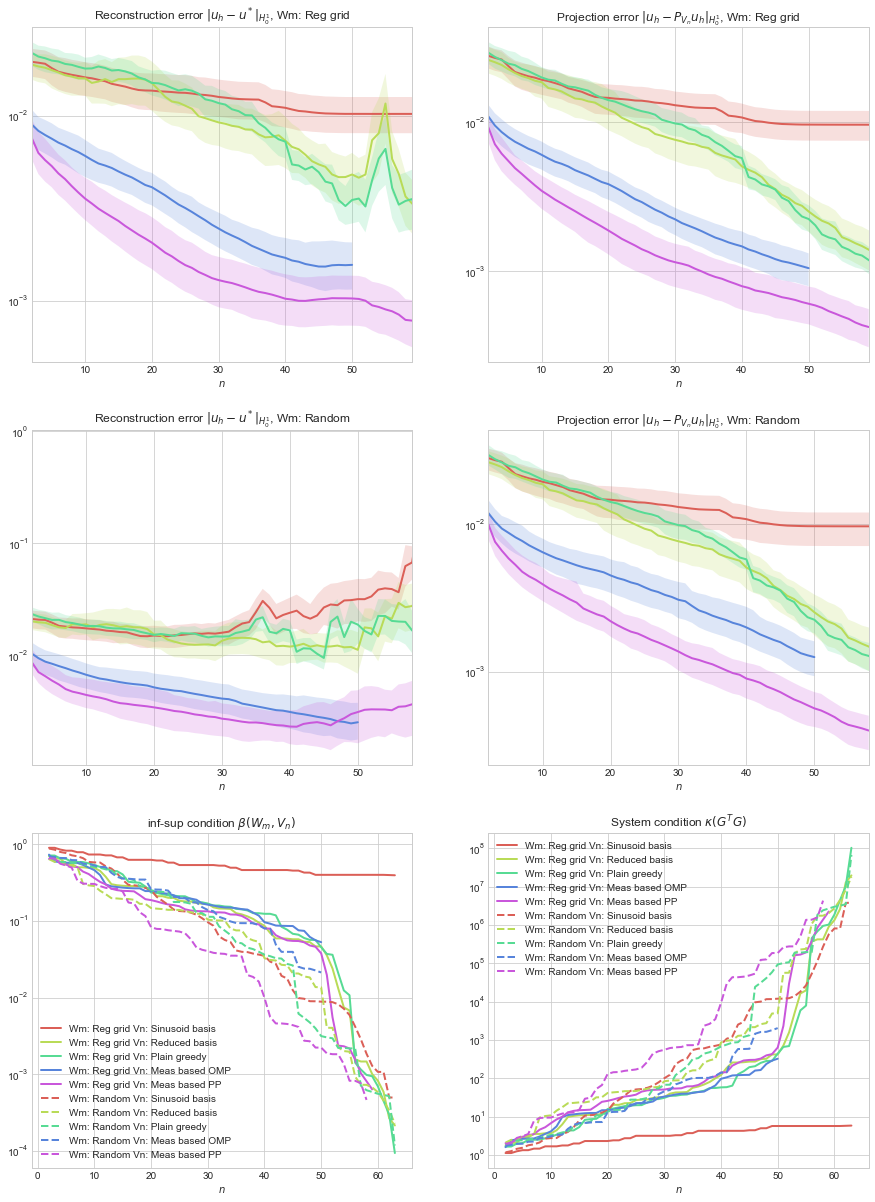

In [29]:
sns.set_palette('hls', len(generic_Vns) + len(adapted_Vns))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,2]

axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Reg grid'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Random'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Random'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for i, Wm_label in enumerate(['Reg grid', 'Random']):
    for j, Vn_label in enumerate(generic_Vns_labels):
        
        Vn_n = generic_Vns[j].n
        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        plt.sca(axs[i*2])
        sns.tsplot(stats[0, i, j, :, 2:Vn_n], range(2, Vn_n), lw=lws[i], color=cp[j], ci=[100])
        #for k in range(len(us)):
        #    plt.plot(range(2, Vn_n), stats[0, i, j, k, 2:Vn_n], ':', lw=1, color=cp[j])
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        sns.tsplot(stats[1, i, j, :, 2:Vn_n], range(2, Vn_n),  lw=lws[i],color=cp[j], ci=[100])
        #for k in range(len(us)):
        #    plt.plot(range(2, Vn_n), stats[1, i, j, k, 2:Vn_n], ':', label=label, lw=1, color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
    for j_i, Vn_label in enumerate(adapted_Vns_labels):
        j = j_i + len(generic_Vns)

        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        
        # Some funny biz about n...
        Vn_ns = [Vn.n for Vn in adapted_Vns[i][j_i]]
        Vn_n = min(Vn_ns)
        
        plt.sca(axs[i*2])
        sns.tsplot(stats[0, i, j, :, 2:Vn_n], range(2, Vn_n), lw=lws[i], color=cp[j], ci=[100])
        #for k in range(len(us)):
        #    plt.plot(range(2, Vn_n), stats[0, i, j, k, 2:Vn_n], ':', label=label, lw=1, color=cp[j])
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        sns.tsplot(stats[1, i, j, :, 2:Vn_n], range(2, Vn_n), lw=lws[i], color=cp[j], ci=[100])
        #for k in range(len(us)):
        #    plt.plot(range(2, Vn_n), stats[1, i, j, k, 2:Vn_n], ':', label=label, lw=1, color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
plt.savefig('GreedyMeasSelectionResults.pdf')
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


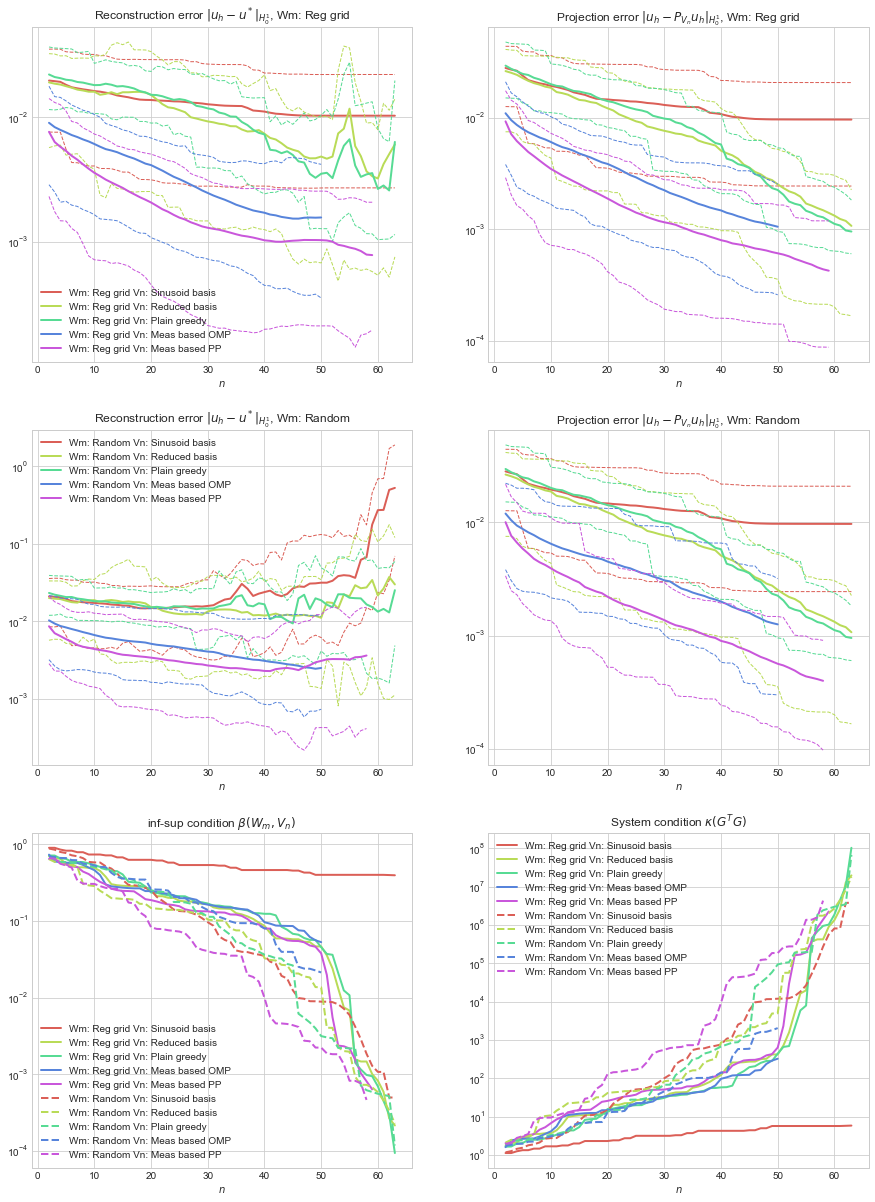

In [31]:
sns.set_palette('hls', len(generic_Vns) + len(adapted_Vns))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,2]

axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Reg grid'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Random'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Random'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for i, Wm_label in enumerate(['Reg grid', 'Random']):
    for j, Vn_label in enumerate(generic_Vns_labels):
        
        Vn_n = generic_Vns[j].n
        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        plt.sca(axs[i*2])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
    for j_i, Vn_label in enumerate(adapted_Vns_labels):
        j = j_i + len(generic_Vns)

        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        
        # Some funny biz about n...
        Vn_ns = [Vn.n for Vn in adapted_Vns[i][j_i]]
        Vn_n = min(Vn_ns)
        
        plt.sca(axs[i*2])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)

        
plt.savefig('GreedyMeasSelectionResults.pdf')
plt.show()

IndexError: list index out of range

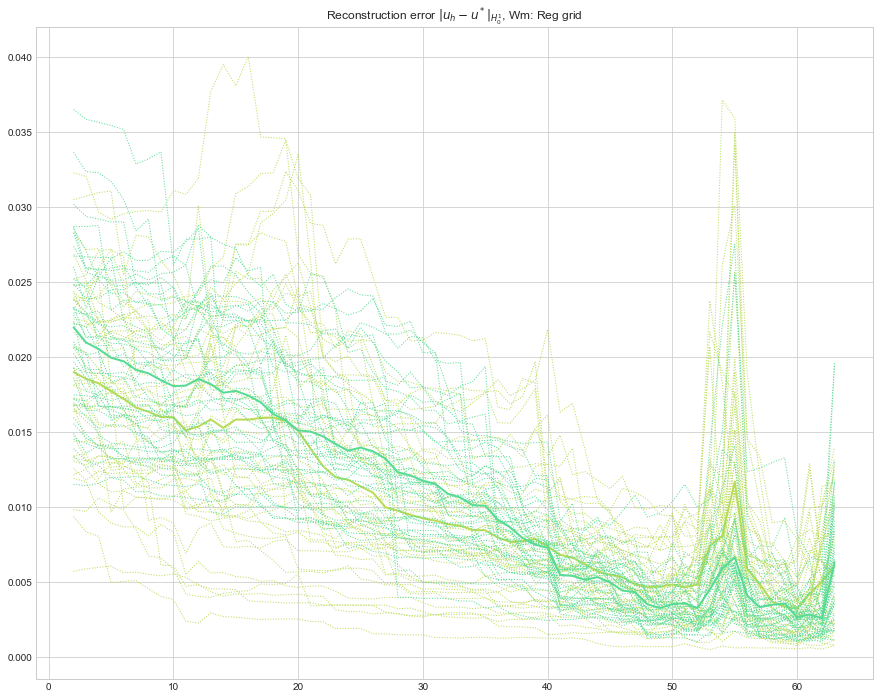

In [34]:
sns.set_palette('hls', len(generic_Vns) + len(adapted_Vns))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,2]

axs = []
fig = plt.figure(figsize=(15, 12))
axs.append(fig.add_subplot(1, 1, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid'))

for i, Wm_label in enumerate(['Reg grid', 'Random']):
    for j, Vn_label in enumerate(generic_Vns_labels[1:]):
        j=j+1
        Vn_n = generic_Vns[j].n
        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        plt.sca(axs[i*2])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        for k in range(len(us)):
            plt.plot(range(2, Vn_n), stats[0, i, j, k, 2:Vn_n], ':', lw=1, color=cp[j])
        
    """for j_i, Vn_label in enumerate(adapted_Vns_labels):
        j = j_i + len(generic_Vns)

        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        
        # Some funny biz about n...
        Vn_ns = [Vn.n for Vn in adapted_Vns[i][j_i]]
        Vn_n = min(Vn_ns)
        
        plt.sca(axs[i*2])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        for k in range(len(us)):
            plt.plot(range(2, Vn_n), stats[0, i, j, k, 2:Vn_n], ':', lw=1, color=cp[j])"""
        
        
plt.show()

### Old code

In [ ]:
WmVn_pairs = []
WmVn_pair_labels = []

for Wm, Wm_label in zip([Wm_reg, Wm_rand], ['Reg grid', 'Random']):
    for Vn, Vn_label in zip([Vn_sin, Vn_red, g.Vn], ['Sinusoid basis', 'Reduced basis', 'Plain greedy']):
        label = 'Wm: ' + Wm_label + ', Vn: ' + Vn_label
        WmVn_pair_labels.append(label)
        WmVn_pairs.append([])
        print(label)
        for u in us:
            WmVn_pairs[-1].append([Wm, Vn])
    
    
    algs = [pat.MeasBasedOMP(dictionary, us[0], Wm, Vn=pat.PWBasis(), verbose=True), 
            pat.MeasBasedPP(dictionary, us[0], Wm, Vn=pat.PWBasis(), verbose=True)]
    
    # CALL CONSTRUCTOR HERE AND INITIALISE THE BIG DOT PROD DICTIONARY HERE YA DUMMY
    for alg, Vn_label in zip(algs, ['Meas based OMP', 'Meas based PP']):
        label = 'Wm: ' + Wm_label + ', Vn: ' + Vn_label
        WmVn_pair_labels.append(label)
        print(label)
        WmVn_pairs.append([])
        for i, u in enumerate(us):
            if i > 0:
                alg.reset_u(u)

            alg.construct_to_n(m)
            WmVn_pairs[-1].append([Wm, alg.Vn])
            
            

In [75]:
stats = np.zeros([6, len(WmVn_pairs), n_us, m])

for j, u_pairs in enumerate(WmVn_pairs):
    label = WmVn_pair_labels[j]
    print('\nReconstructions for pair: ' + label + ' u', end='')
    
    for k, pair in enumerate(u_pairs):
        
        Wm = pair[0]
        Vn_big = pair[1].orthonormalise()
        
        u = us[k]
        print('{0}, '.format(k), end='')

        for i, n in enumerate(range(2,min(Vn_big.n, m))):

            Vn = Vn_big.subspace(slice(0,n))
            if k == 2 and j > 0:
                pdb.set_trace()
            u_p_v = Vn.project(u)
            BP = pat.BasisPair(Wm, Vn)
            #FB = BP.make_favorable_basis()
            u_star, v_star, w_p, v_w_p, cond = BP.measure_and_reconstruct(u)

            stats[0, j, k, n] = (u - u_star).norm()
            stats[1, j, k, n] = (u - u_p_v).norm()
            stats[2, j, k, n] = BP.beta()
            stats[3, j, k, n] = cond
            stats[4, j, k, n] = (u_star - v_star).norm()


Reconstructions for pair: Wm: Reg grid, Vn: Sinusoid basis u 0, 1, 2, 3, 4, 5, 

KeyboardInterrupt: 

5


/usr/local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


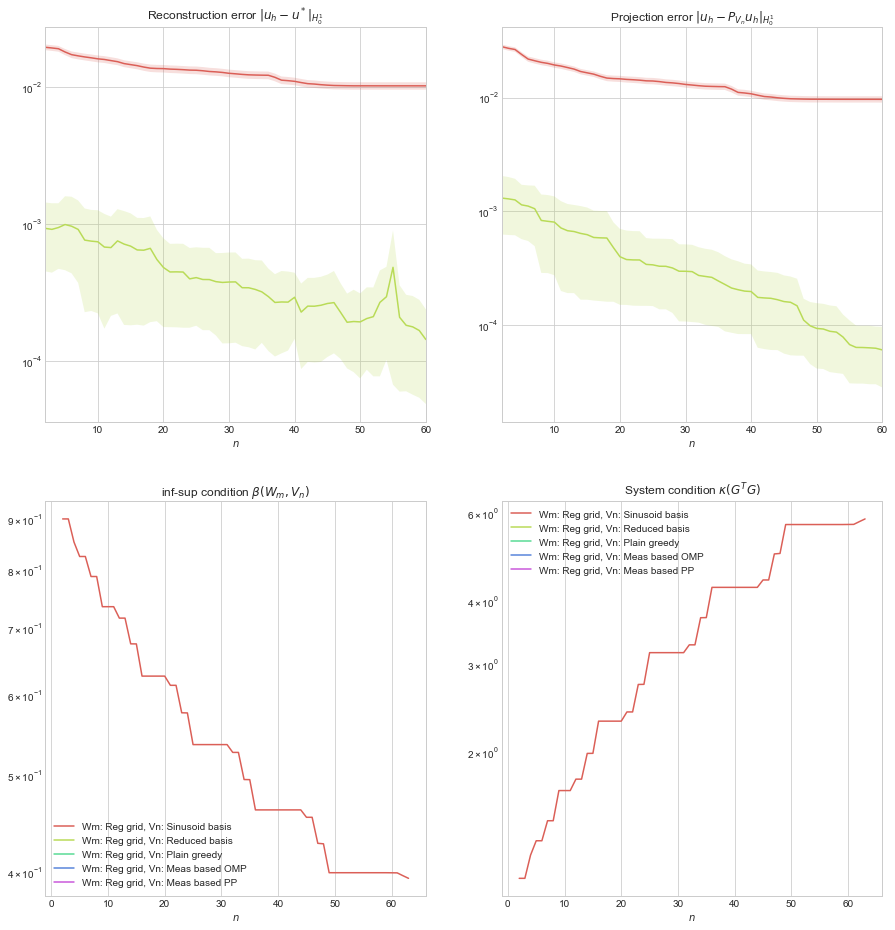

In [73]:
num_res = len(WmVn_pairs)//2
print(num_res)
sns.set_palette('hls', num_res)
cp = sns.color_palette()
sns.set_style('whitegrid')

axs = []
fig = plt.figure(figsize=(15, 16))
axs.append(fig.add_subplot(2, 2, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(2, 2, 2, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(2, 2, 3, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(2, 2, 4, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')
#axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|_{H_0^1}$'))
#axs[-1].set(yscale="log", xlabel='$n$')

plot_i = 2
for j, basis_label in enumerate(WmVn_pair_labels[:num_res]):
    Vn_n = WmVn_pairs[j][k][1].n
    plt.sca(axs[0])
    sns.tsplot(stats[0, j, :, 2:Vn_n], range(2, Vn_n), color=cp[j])
    plt.legend(loc=0)
    plt.sca(axs[1])
    sns.tsplot(stats[1, j, :, 2:Vn_n], range(2, Vn_n), color=cp[j])
    plt.legend(loc=3)
    plt.sca(axs[2])
    plt.plot(range(2, Vn_n), stats[2, j, plot_i, 2:Vn_n], label=basis_label, color=cp[j])
    plt.legend(loc=3)
    plt.sca(axs[3])
    plt.plot(range(2, Vn_n), stats[3, j, plot_i, 2:Vn_n], label=basis_label, color=cp[j])
    plt.legend(loc=2)
"""
for j, basis_label in enumerate(WmVn_pair_labels[num_res:]):
    Vn_n = WmVn_pairs[j+num_res][k][1].n
    plt.sca(axs[0])
    #plt.plot(range(2, Vn_n), stats[0, j+num_res, :, 2:Vn_n], '--', lw=1, label=basis_label, color=cp[j])
    #sns.tsplot(stats[0, j, :, 2:Vn_n], range(2, Vn_n), color=cp[j])

    plt.legend(loc=0)
    plt.sca(axs[1])
    #plt.plot(range(2, Vn_n), stats[1, j+num_res, :, 2:Vn_n], '--', lw=1, label=basis_label, color=cp[j])
    plt.legend(loc=3)
"""
plt.savefig('GreedyMeasSelectionResults.pdf')
plt.show()

In [19]:
WmVn_pair_labels

['Wm: Reg grid, Vn: Sinusoid basis',
 'Wm: Reg grid, Vn: Reduced basis',
 'Wm: Reg grid, Vn: Plain greedy',
 'Wm: Reg grid, Vn: Meas based OMP',
 'Wm: Reg grid, Vn: Meas based PP',
 'Wm: Random, Vn: Sinusoid basis',
 'Wm: Random, Vn: Reduced basis',
 'Wm: Random, Vn: Plain greedy',
 'Wm: Random, Vn: Meas based OMP',
 'Wm: Random, Vn: Meas based PP']